# Quickstart: Collisional Ionization Equilibrium

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [2]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"RHS of e- number density equation: {process.network["e-"]}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -1.46719838641439e-26*sqrt(T)/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Heating rate per cm^-3: -1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Rate coefficient: 1.41621465870114e-10/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Recombination rate per cm^-3: 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
RHS of e- number density equation: -1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [3]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)

system.subprocesses

[Collisional Ionization of H,
 Collisional Ionization of He,
 Collisional Ionization of He+,
 Gas-phase recombination of H+,
 Gas-phase recombination of He+,
 Gas-phase recombination of He++]

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

In [4]:
system.heat

-1.55e-26*n_He+*n_e-/T**0.3647 - 1.2746917300104e-21*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252) - 9.37661057635428e-22*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 4.9524176975855e-22*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.86879354565754e-26*sqrt(T)*n_He++*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

In [5]:
system.print_network_equations()

dn_He+/dt = 2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108)) + 5.66485863480458e-10*n_He++*n_e-/(sqrt(T)*(0.00059608348423851*sqrt(T) + 1.0)**1.748*(0.281807561832489*sqrt(T) + 1.0)**0.252)
dn_e-/dt = 5.85e-11*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108)) - 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978

## Solving ionization equilibrium

We would like to solve for ionization equilibrium given a temperature $T$, overall H number density $n_{\rm H,tot}$, and helium mass fraction $Y$.  We define a dictionary of those input quantities and also one for the initial guesses of the number densities of the species in the reduced network.

In [6]:
Tgrid = np.logspace(3,6,10**6)
ngrid = np.ones_like(Tgrid) * 100
Ygrid = 0.24*np.ones_like(Tgrid)

knowns = {"T": Tgrid, "n_Htot": ngrid, "Y": Ygrid}


Note that by default, the solver only directly solves for $n_{\rm H}$, $n_{\rm He}$ and $n_{\rm He+}$ because $n_{\rm H+}$, $n_{\rm He++}$, and $n_{\rm e-}$ are eliminated by conservation equations. So we only need initial guesses for those 3 quantities. By default the solver takes abundances $x_i = n_i / n_{\rm H,tot}$ as inputs and outputs.

In [7]:
guesses = {
    "H": 0.5*np.ones_like(Tgrid),
    "He": 1e-5*np.ones_like(Tgrid),
    "He+": 1e-5*np.ones_like(Tgrid)
}
sol = system.chemical_equilibrium(knowns, guesses,tol=1e-4)
print(sol)

(n_He+, n_H, n_He)
{'He+': Array([1.2797412e-09, 1.2830607e-09, 1.2790252e-09, ..., 6.5619070e-06,
       6.5618315e-06, 6.5617519e-06], dtype=float32), 'H': Array([9.9993604e-01, 9.9993604e-01, 9.9993604e-01, ..., 6.0612069e-07,
       6.0611501e-07, 6.0610915e-07], dtype=float32), 'He': Array([7.8937270e-02, 7.8937270e-02, 7.8937270e-02, ..., 2.3453643e-09,
       2.3453146e-09, 2.3452629e-09], dtype=float32), 'H+': Array([6.393433e-05, 6.393433e-05, 6.393433e-05, ..., 9.999994e-01,
       9.999994e-01, 9.999994e-01], dtype=float32), 'e-': Array([8.4122337e-05, 8.4122323e-05, 8.4122323e-05, ..., 1.1578876e+00,
       1.1578876e+00, 1.1578876e+00], dtype=float32), 'He++': Array([1.0093363e-05, 1.0093359e-05, 1.0093363e-05, ..., 7.8940809e-02,
       7.8940809e-02, 7.8940809e-02], dtype=float32)}


(0.0001, 3)

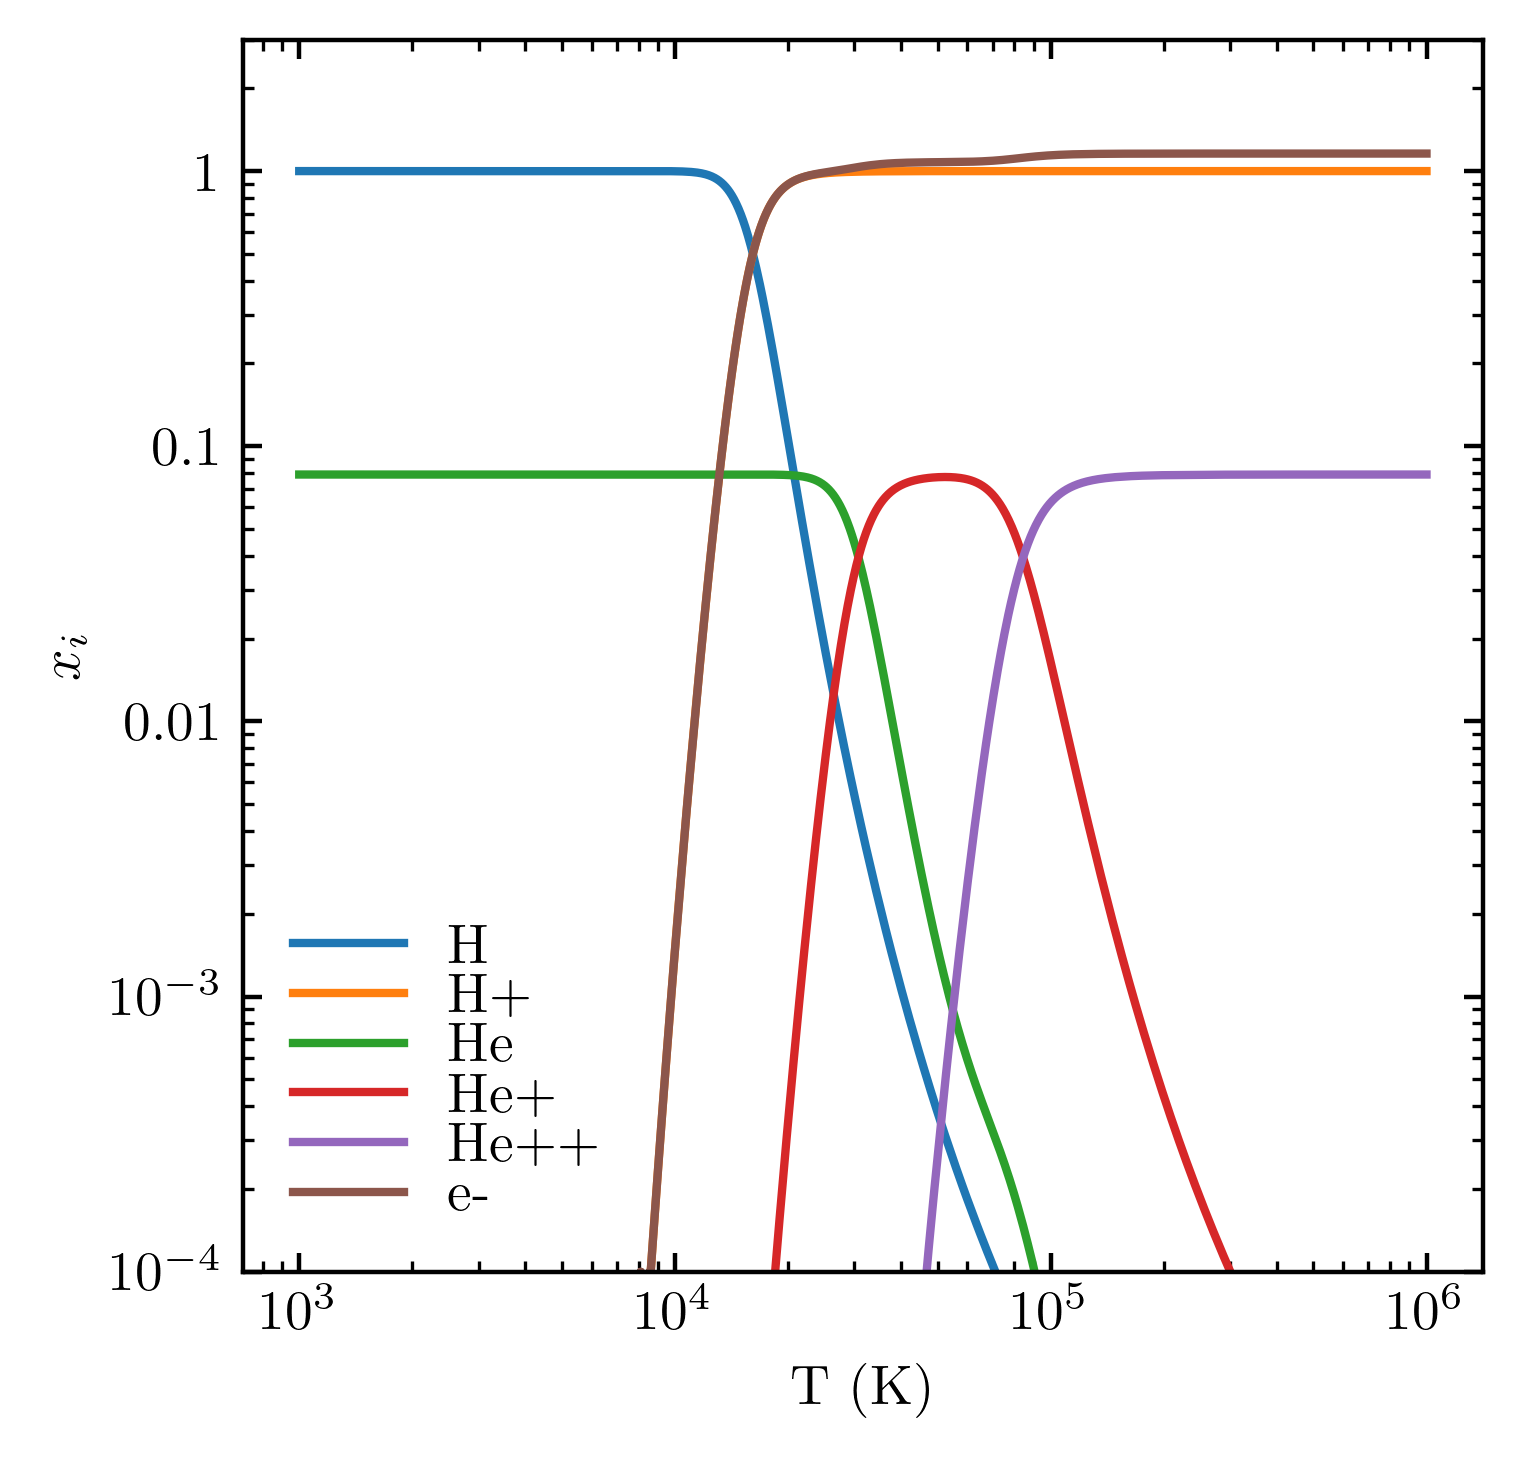

In [8]:
for i, xi in sorted(sol.items()):
    plt.loglog(Tgrid, xi, label=i)
plt.legend(labelspacing=0)
plt.ylabel("$x_i$")
plt.xlabel("T (K)")
plt.ylim(1e-4,3)